# Identification of a 1-DOF Mass-Spring-Damper System with the Least Squares Complex Exponential Algorithm

***

In our first notebook, we started our journey into system identification by exploring the AutoRegressive with eXogenous inputs (ARX) model. This model allowed us to predict the response of a 1-DOF mass-spring-damper system to an external force based on the (artificial) measurement of some input-output data. Now, we'll tackle the same 1-DOF mass-spring-damper system using a different approach: the Least Squares Complex Exponential (LSCE) algorithm.

While the ARX model allowed us to predict the system's response in time, it didn't directly give us insight into the system's fundamental characteristics like natural frequency and damping ratio. The LSCE algorithm, on the other hand, is specifically designed to extract these modal parameters. Think of it as a specialized tool that can decode the system's "DNA" - its natural vibration patterns.

In the realm of modal analysis, there are two main approaches:
1. **Time Domain Methods**: These analyze how the system's response evolves over time
2. **Frequency Domain Methods**: These look at how the system responds to different frequencies

The LSCE algorithm is a time domain method - just like the ARX model approach - that works by fitting complex exponentials to the system's Impulse Response Function (IRF). Imagine throwing a pebble into a pond - the resulting ripples are like our system's response, and the LSCE algorithm helps us understand the fundamental patterns in these ripples.

We'll follow a structured approach with these key steps:
* [Theoretical Background](#theoretical-background)
    * [IRF of the 1-DOF Mass-Spring-Damper System](#irf)
    * [LSCE Algorithm](#lsce)
* [Parameter Estimation from Impulse Response Data](#estimation-impulse-response)
    * [Data Generation](#data-generation-impulse)
    * [Parameter Estimation](#parameter-estimation-impulse)
    * [Model Validation](#model-validation-impulse)
* [Parameter Estimation from Random Response Data](#estimation-random-response)
    * [Data Generation](#data-generation-random)
    * [Parameter Estimation](#parameter-estimation-random)
    * [Model Validation](#model-validation-random)
* [Conclusion](#conclusion)

## Theoretical Background <a name="theoretical-background"></a>

***

### IRF of the 1-DOF Mass-Spring-Damper System <a name="irf"></a>

The key starting point of LSCE is the assumption that any linear system's impulse response can be expressed as a sum of complex exponentials. This isn't a random guess if you think about it, as the impulse response of an underdamped 1-DOF mass-spring-damper system is a decaying sinusoid, which can be written as a complex exponential.

To convince you of this, let's derive the impulse response of our 1-DOF system below and express it in complex exponential form.

![1-DOF Mass-Spring-Damper System](resources/01_MassSpringDamper.svg)

We recall the equation of motion for this system:

$$
m\ddot{x} + c\dot{x} + kx = F(t).
$$

The impulse response is the system's response to an impulse load. This load is characterized by a sudden rise in the applied force, followed by a rapid decrease to zero, as you can see in the plot below. The key assumption is that this impulse load is applied over a very short time interval $T_p$, which is much less than the system's natural vibration period $T_d$. Within this very short time, we can assume that the system doesn't have time to move, so the displacement remains zero. However, the velocity of the system can change during this time interval, as shown in the plot below.

![Impulse Load](resources/02_ImpulseLoad.svg)

We can find the velocity at the end of this time interval by integrating the equation of motion over the interval itself:

$$
\int_{0}^{T_p} \left( m\ddot{x} + c\dot{x} + kx \right) \mathrm{d}t = \int_{0}^{T_p} F(t) \mathrm{d}t.
$$

On the right hand side, the integral of the force is simply the impulse $I$:

$$
\int_{0}^{T_p} F(t) \mathrm{d}t = I.
$$

The integral of the left hand side reads:

$$
\left[m\dot{x}(t) + cx(t) + kx(t)t\right]_{0}^{T_p} = m\dot{x}(T_p),
$$

where we used our assumption that $x(0) = x(T_p) = 0$. This gives us the velocity at the end of the impulse:

$$
\dot{x}(T_p) = \frac{I}{m}.
$$

Essentially, the impulse load gives the system a velocity kick, which corresponds to considering the free vibration response of the system with an initial velocity $\dot{x}(0)\approx\dot{x}(T_p)=I/m$ and zero initial displacement.

The equation of motion is then a linear homogeneous differential equation with constant coefficients $\left(F(t)=0\right)$, and it has the following exponential solution:

$$
x(t) = A e^{st} = A e^{\left(s_r + is_i\right)t} = A e^{s_r t} e^{is_i t},
$$

where $A$ is an unknown constant and $s = s_r + is_i$ is a complex number. With the help of Euler's formula, we can see that $e^{is_i t}$ represents an oscillatory part of the solution:

$$
e^{is_i t} = \cos(s_i t) + i \sin(s_i t),
$$

where $s_i$ represents the frequency of oscillation of the system.

To find the solution for $x(t)$, we need to determine the real and imaginary parts of $s$. We differentiate $x(t)$ once and twice:

$$
\dot{x}(t) = s A e^{st}\\
\ddot{x}(t) = s^2 A e^{st},
$$

and we substitute these expressions into the equation of motion:

$$
m s^2 A e^{st} + c s A e^{st} + k A e^{st} = \left( m s^2 + c s + k \right) A e^{st} = 0.
$$

Since $A e^{st} \neq 0$, to find $s$ we need to solve the following equation:

$$
m s^2 + c s + k = 0,
$$

which is called the characteristic equation of the system. The solutions of this equation are the roots of the polynomial:

$$
s_{1,2} = -\frac{c \pm \sqrt{c^2 - 4mk}}{2m}.
$$

The roots of the characteristic equation can be real or complex, depending on the value of $c^2 - 4mk$.

The general solution of the homogeneous differential equation of the system is represented by the linear superposition of the individual solutions:

$$
x(t) = A_1 e^{s_1 t} + A_2 e^{s_2 t},
$$

where $A_1$ and $A_2$ are constants that depend on the initial conditions of the system.

It is convenient to rewrite the roots $s_{1,2}$ in the following way:

$$
s_{1,2} = -\frac{c \pm \sqrt{c^2 - 4mk}}{2m} = -\frac{c}{2m} \pm \left(\frac{c^2}{4m^2} - \frac{k}{m}\right)^{1/2} = -\frac{c}{2m} \pm \sqrt{\frac{k}{m}}\left(\frac{c^2}{4mk} - 1\right)^{1/2}.
$$

In this expression we can recognize the natural frequency of the undamped system $\omega_0 = \sqrt{k/m}$ and the damping ratio $\zeta = c/2\left(mk\right)^{1/2}$. Consequently, we can rewrite the roots as:

$$
s_{1,2} = -\zeta \omega_0 \pm \omega_0 \left(\zeta^2 - 1\right)^{1/2}.
$$

We can then assess the nature of the roots based on the value of the damping ratio $\zeta$:
* If $\zeta < 1$, we have two complex conjugate roots and the system is underdamped.
* If $\zeta = 1$, we have one double real root ($s_1=s_2$) and the system is critically damped.
* If $\zeta > 1$, we have two distinct real roots and the system is overdamped.

Since aerospace structures are typically characterized by underdamped behavior, we will focus on this case. The roots of the characteristic equation can be written as:

$$
s_{1,2} = -\zeta \omega_0 \pm i \omega_0 \sqrt{1 - \zeta^2}.
$$

We know that the imaginary part of the roots represents the frequency of oscillation of the system, which is called the damped natural frequency:

$$
\omega_d = \omega_0 \sqrt{1 - \zeta^2}.
$$

The general solution of the system can be rewritten as:

$$
x(t) = A_1 e^{\left(-\zeta \omega_0 + i \omega_d\right)t} + A_2 e^{\left(-\zeta \omega_0 - i \omega_d\right)t}.
$$

See? A sum of complex exponentials! I told you that ;-)

Now, let's understand what $A_1$ and $A_2$ represent. Since we're dealing with a real physical system, $x(t)$ must be real. This means $A_1$ and $A_2$ must be complex conjugates. We can write them in polar form:

$$
A_1 = \frac{A}{2}e^{i\phi} \text{ and } A_2 = \frac{A}{2}e^{-i\phi},
$$

where $A$ is a real amplitude and $\phi$ is the phase angle.

Substituting these expressions:

$$
x(t)=\frac{A}{2}e^{i\phi} e^{(-\zeta \omega_0 + i \omega_d)t} + \frac{A}{2}e^{-i\phi} e^{(-\zeta \omega_0 - i \omega_d)t}
$$

Let's factor out the real exponential term $e^{-\zeta \omega_0 t}$:

$$
x(t)=\frac{A}{2}e^{-\zeta \omega_0 t}(e^{i\phi}e^{i\omega_d t} + e^{-i\phi}e^{-i\omega_d t})
$$

Now, recall Euler's formula for cosine:

$$
\cos(\theta) = \frac{e^{i\theta} + e^{-i\theta}}{2}
$$

Looking at our expression, and considering $\theta = \omega_d t + \phi$, we can rewrite it as:

$$
x(t) = Ae^{-\zeta \omega_0 t}\cos(\omega_d t + \phi).
$$

This expression represents a decaying sinusoid, where $A$ is the constant amplitude, $e^{-\zeta \omega_0 t}$ is the decay term, and $\cos(\omega_d t + \phi)$ is the oscillatory part of the response. This last term indicates that the system vibrates at the damped natural frequency $\omega_d$ with a phase shift $\phi$. The amplitude $A$ and the phase shift $\phi$ are the two unknown constants that can be determined considering the initial conditions of the system.

### LSCE Algorithm <a name="lsce"></a>

Now that we understand how the impulse response of our 1-DOF system can be expressed as a sum of complex exponentials in continuous time:

$$x(t) = A_1e^{s_1t} + A_2e^{s_2t}$$

where $s_{1,2} = -\zeta\omega_0 \pm i\omega_d$, let's see how this translates to the discrete-time domain where our measurements actually live.

When we sample the continuous response $x(t)$ at regular intervals $\Delta t$, we get a sequence of discrete values $x[j]$ where $j$ is the sample index and $t = j\Delta t$. The discrete-time response can be written as:

$$x[j] = A_1e^{s_1j\Delta t} + A_2e^{s_2j\Delta t}$$

Let's define the discrete-time poles $\lambda_1 = e^{s_1\Delta t}$ and $\lambda_2 = e^{s_2\Delta t}$. This gives us:

$$x[j] = A_1\lambda_1^j + A_2\lambda_2^j$$

This is known as a Prony series. The key insight of the LSCE method is that this sequence satisfies a difference equation:

$$\beta_0x[j] + \beta_1x[j+1] + \beta_2x[j+2] = 0$$

where $\beta_0$, $\beta_1$, and $\beta_2$ are real coefficients we need to determine.

To understand why this difference equation must be true, let's substitute our expression for $x[j]$ into it:

$$\beta_0(A_1\lambda_1^j + A_2\lambda_2^j) + \beta_1(A_1\lambda_1^{j+1} + A_2\lambda_2^{j+1}) + \beta_2(A_1\lambda_1^{j+2} + A_2\lambda_2^{j+2}) = 0$$

Regrouping terms for each exponential:

$$A_1\lambda_1^j(\beta_0 + \beta_1\lambda_1 + \beta_2\lambda_1^2) + A_2\lambda_2^j(\beta_0 + \beta_1\lambda_2 + \beta_2\lambda_2^2) = 0$$

This equation must hold for all $j$. This means that both terms must be zero independently, leading to:

$$\beta_0 + \beta_1\lambda_1 + \beta_2\lambda_1^2 = 0$$
$$\beta_0 + \beta_1\lambda_2 + \beta_2\lambda_2^2 = 0$$

These equations hold if $\lambda_1$ and $\lambda_2$ are the roots of the quadratic equation:

$$\beta_0 + \beta_1\lambda + \beta_2\lambda^2 = 0$$

Essentially, by estimating the $\beta$ coefficients from our measured data and by solving the above quadratic equation, we can recover the discrete-time poles $\lambda_1$ and $\lambda_2$. From these, we can extract the modal parameters $\omega_0$ and $\zeta$.

The difference equation gives us a way to set up a system of equations using our impulse response data. In fact, given $N$ samples of the impulse response, we can write the following system of difference equations:

$$
\begin{cases}
    \beta_0x[0] + \beta_1x[1] + \beta_2x[2] = 0 \\
    \beta_0x[1] + \beta_1x[2] + \beta_2x[3] = 0 \\
    \cdots \\
    \beta_0x[N-2] + \beta_1x[N-1] + \beta_2x[N] = 0.
\end{cases}
$$

By taking $\beta_2 = 1$, we can rewrite this system in matrix form:

$$
\begin{bmatrix} 
x[0] & x[1]\\
x[1] & x[2]\\
\vdots & \vdots\\
x[N-2] & x[N-1]
\end{bmatrix}
\begin{bmatrix}
\beta_0 \\
\beta_1
\end{bmatrix} = 
-\begin{bmatrix}
x[2] \\
x[3] \\
\vdots \\
x[N]
\end{bmatrix}
$$

Or more compactly:
$$\boldsymbol{X}\boldsymbol{\beta} = -\boldsymbol{y}$$

This is an overdetermined system that we can solve using the least squares method:

$$\boldsymbol{\beta} = -(\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\boldsymbol{y}$$

Once we find $\beta_0$ and $\beta_1$, we can find $\lambda_1$ and $\lambda_2$ by solving the quadratic equation:

$$\beta_0 + \beta_1\lambda + \lambda^2 = 0$$

These roots are related to the system continuous-time poles $s_{1,2}$. Since the poles are determined by the undamped natural frequency $\omega_0$ and the damping ratio $\zeta$, as shown below:

$$
s_1 = -\zeta\omega_0 + i\omega_0\sqrt{1-\zeta^2}\\[2ex]
s_2 = -\zeta\omega_0 - i\omega_0\sqrt{1-\zeta^2},
$$

we can derive the natural frequency and the damping ratio as:

$$
\omega_0 = \frac{1}{\Delta t}\sqrt{\ln\lambda_1\ln\lambda_2}\\[2ex]
\zeta = \frac{-\ln\left(\lambda_1\lambda_2\right)}{2\omega_0\Delta t}.
$$

This process gives us direct access to the system's natural frequency and damping ratio, which was our original goal!

In the next sections, we'll implement this algorithm and apply it to our mass-spring-damper system.

## Parameter Estimation from Impulse Response Data <a name="estimation-impulse-response"></a>

***

Similarly to our previous notebook, we are now going to identify the parameters of the 1-DOF mass-spring-damper system using synthetic data. However, this time we are going to use the LSCE algorithm, which is specifically designed to work with impulse response data. Consequently, we are going to generate impulse response data to perform the identification and random response data to validate the model. For both excitations, we observe the response of the system for 20 seconds with a sampling frequency of 100 Hz, meaning that we acquire 2000 samples for each dataset.

### Data Generation <a name="data-generation-impulse"></a>

Let's start by defining the properties of our system and its equation of motion in state-space form.

In [1]:
MASS = 8  # mass [kg]
STIFFNESS = 4000  # stiffness constant [N/m]
DAMPING = 7  # damping constant [Ns/m]


def mass_spring_damper(state, t, force):
    """
    Define system dynamics: dq/dt = f(q, t)

    Parameters:
    state (array): [displacement, velocity]
    t (float): Time
    force (function): External force signal, inputted as a function

    Returns:
    array: State derivatives [velocity, acceleration]
    """
    # Unpack state variables
    x, xdot = state

    # Calculate acceleration based on the equation of motion
    xddot = (-STIFFNESS * x - DAMPING * xdot + force(t)) / MASS

    # Return state derivatives
    return [xdot, xddot]

Now we generate the impulse response data by defining an initial velocity given by an impulse of 20 Ns. We also need to define a dummy zero force signal to use the `odeint` solver with the `mass_spring_damper` function. 

We solve the system of differential equations and plot the impulse response data.

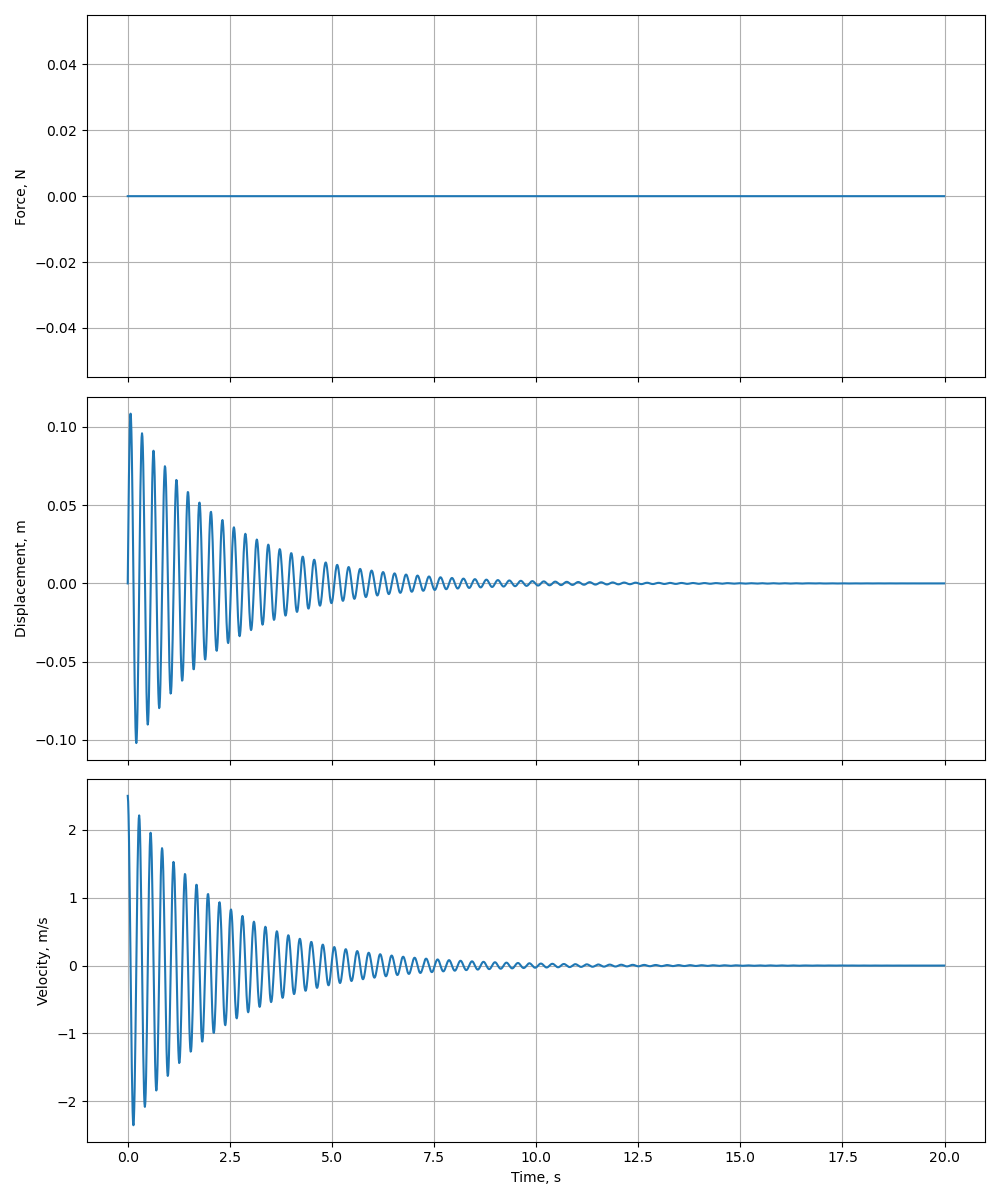

In [2]:
import numpy as np  # import numpy library for numerical calculations
from scipy.interpolate import interp1d  # import interp1d function for interpolation
from scipy.integrate import odeint  # import odeint function for solving ODEs
import matplotlib.pyplot as plt  # import matplotlib library for plotting

# Enable interactive plots
%matplotlib widget

# Create time array
t_span = 20  # [s]
f_sampling = 100  # sampling frequency [Hz]
t_vector = np.arange(0, t_span, 1 / f_sampling)  # time vector [s]

# Create interpolated force function
impulse_force_signal = np.zeros_like(t_vector)
impulse_force_function = interp1d(t_vector, impulse_force_signal, bounds_error=False, fill_value=0)

# Calculate initial velocity based on impulse
impulse = 20  # [Ns]
xdot0 = impulse / MASS

# Initial conditions [x0, xdot0]
initial_state = [0, xdot0]

# Solve ODE
solution = odeint(mass_spring_damper, initial_state, t_vector, args=(impulse_force_function,))

# Extract displacement and velocity
impulse_displacement = solution[:, 0]
impulse_velocity = solution[:, 1]

# Create figure with three subplots
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 12))

# Plot force
axes[0].plot(t_vector, impulse_force_signal)
axes[0].set_ylabel("Force, N")
axes[0].grid(True)

# Plot displacement
axes[1].plot(t_vector, impulse_displacement)
axes[1].set_ylabel("Displacement, m")
axes[1].grid(True)

# Plot velocity
axes[2].plot(t_vector, impulse_velocity)
axes[2].set_ylabel("Velocity, m/s")
axes[2].grid(True)
axes[2].set_xlabel("Time, s")

# Set layout and show plot
plt.tight_layout()
plt.show()

Successively, we excite the system with a random force signal and plot the random response data.

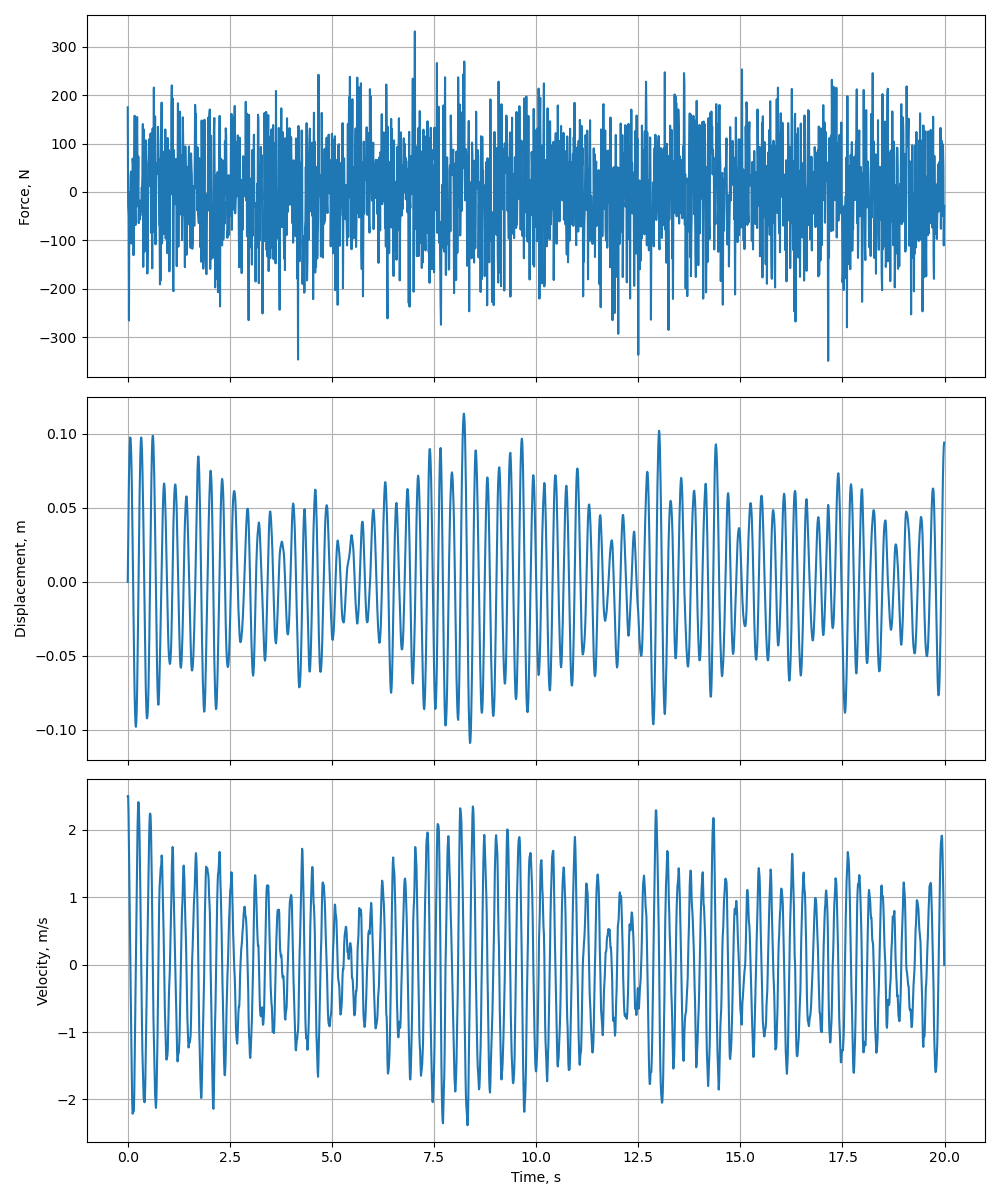

In [3]:
# Generate random force signal
np.random.seed(11)  # set random seed for reproducibility
force_amplitude = 100  # force amplitude [N]
random_force_signal = force_amplitude * np.random.randn(
    len(t_vector)
)  # random force signal [N]

# Create interpolated force function
random_force_function = interp1d(
    t_vector, random_force_signal, bounds_error=False, fill_value=0
)

# Solve ODE
solution = odeint(
    mass_spring_damper, initial_state, t_vector, args=(random_force_function,)
)

# Extract displacement and velocity
random_displacement = solution[:, 0]
random_velocity = solution[:, 1]

# Create figure with three subplots
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 12))

# Plot force
axes[0].plot(t_vector, random_force_signal)
axes[0].set_ylabel("Force, N")
axes[0].grid(True)

# Plot displacement
axes[1].plot(t_vector, random_displacement)
axes[1].set_ylabel("Displacement, m")
axes[1].grid(True)

# Plot velocity
axes[2].plot(t_vector, random_velocity)
axes[2].set_ylabel("Velocity, m/s")
axes[2].grid(True)
axes[2].set_xlabel("Time, s")

# Set layout and show plot
plt.tight_layout()
plt.show()

### Parameter Estimation <a name="parameter-estimation-impulse"></a>

We can now estimate the parameters of the system using the LSCE algorithm. We start by defining the function `estimate_lsce_parameters` that computes the $\beta$ coefficients.

In [4]:
def estimate_lsce_parameters(x):
    """
    Estimate the Least Squares Complex Exponential (LSCE) parameters

    Parameters:
    x (array): Output signal

    Returns:
    float: beta_0 parameter
    float: beta_1 parameter
    """
    # Find number of samples
    N = len(x)

    # Create output vector
    y = np.atleast_2d(x[2:]).T

    # Create observation matrix
    X = np.vstack([x[0 : N - 2], x[1 : N - 1]]).T

    # Calculate the LSCE parameters
    betas = -np.linalg.inv(X.T @ X) @ X.T @ y

    # Return the LSCE parameters
    return betas[0, 0], betas[1, 0]

Then we define the function `estimate_modal_parameters` that computes the natural frequency and damping ratio of the system from the $\beta$ coefficients.

In [5]:
def estimate_modal_parameters(beta_0, beta_1, fs):
    """
    Estimate the modal parameters

    Parameters:
    beta_0 (float): beta_0 parameter
    beta_1 (float): beta_1 parameter
    fs (float): Sampling frequency [Hz]

    Returns:
    float: natural frequency
    float: damping ratio
    """
    # Calculate the discrete-time poles
    lambdas = np.roots([1, beta_1, beta_0])

    # Calculate natural frequency and damping ratio
    omega = fs * np.sqrt(np.log(lambdas[0]) * np.log(lambdas[1]))
    zeta = -fs * np.log(lambdas[0] * lambdas[1]) / (2 * omega)

    # Return the modal parameters
    return np.real(omega), np.real(zeta)

Once we have calculated the estimated modal parameters, we can reuse the equation $\boldsymbol{X}\boldsymbol{\beta} = -\boldsymbol{y}$ to predict the system's output and compare the prediction with the measured output. To do this we define the function `compare_output`, which takes as input the output signal, the $\beta$ coefficients, and the time vector, and plots the measured and predicted output signals.

In [6]:
def compare_output(x, beta_0, beta_1, t):
    """
    Compare measured and estimated output using ARX parameters

    Parameters:
    y (array): Output data, shape (N,)
    beta_0 (float): beta_0 parameter
    beta_1 (float): beta_1 parameter
    t (array): Time vector, shape (N,)

    Returns:
    Axes: Matplotlib Axes object
    """
    # Find number of samples
    N = len(x)

    # Create observation matrix
    X = np.vstack([x[0 : N - 2], x[1 : N - 1]]).T

    # Create beta vector
    beta = np.atleast_2d(np.array([beta_0, beta_1])).T

    # Calculate predicted output
    minus_y = X @ beta
    y = - minus_y

    # Plot measured and predicted output
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(t, x, label="Measured")
    ax.plot(t[2:], y, label="Estimated")
    ax.set_xlabel("Time, s")
    ax.set_ylabel("Displacement, m")
    ax.legend()
    ax.grid(True)
    
    # Return Axes object
    return ax

We apply these functions to the impulse response data and print the estimated natural frequency and damping ratio.

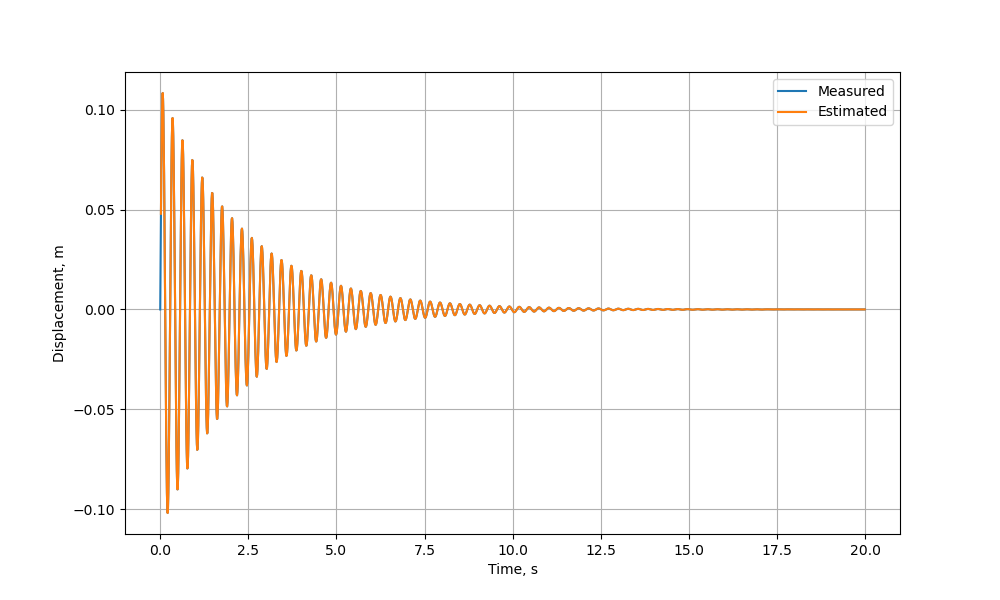


Natural frequency
- true: 22.36 rad/s
- estimated: 22.36 rad/s

Damping ratio
- true:  0.02
- estimated: 0.02



In [7]:
beta_0, beta_1 = estimate_lsce_parameters(impulse_displacement)
omega, zeta = estimate_modal_parameters(beta_0, beta_1, f_sampling)
compare_output(impulse_displacement, beta_0, beta_1, t_vector)
plt.show()
print(f"""
Natural frequency
- true: {np.sqrt(STIFFNESS / MASS):.2f} rad/s
- estimated: {omega:.2f} rad/s

Damping ratio
- true: {DAMPING / (2 * np.sqrt(MASS * STIFFNESS)): .2f}
- estimated: {zeta:.2f}
""")

We can observe that we basically have an exact match between the measured and predicted output signals, and between the true and estimated modal parameters. This result should be of no surprise, as we are using synthetic data where the only source of error is the numerical integration of the differential equations, which is very accurate.

### Model Validation <a name="model-validation-impulse"></a>

Finally, we validate the model by comparing the predicted output with the measured output for the random response data.

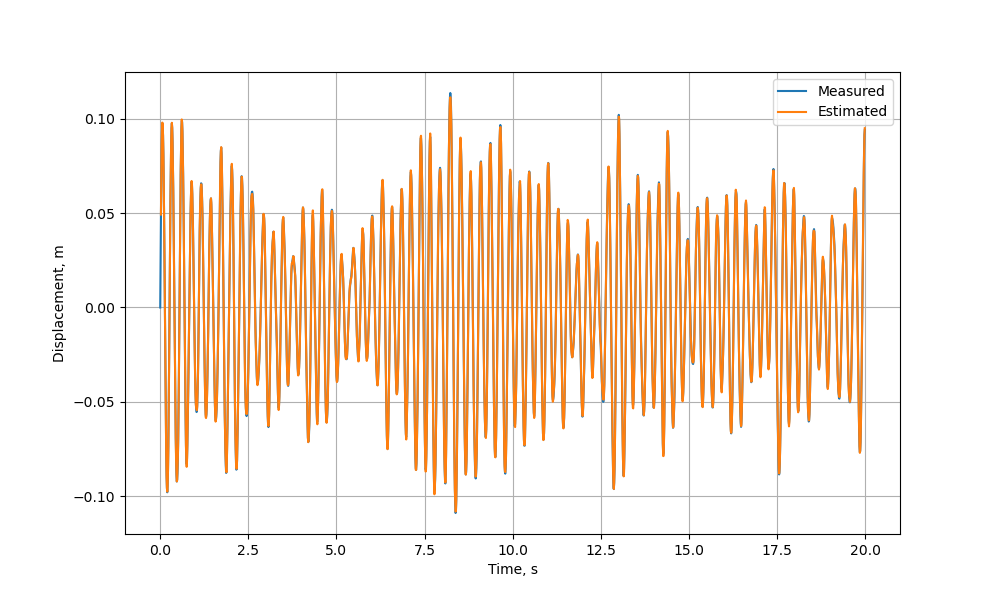

In [8]:
compare_output(random_displacement, beta_0, beta_1, t_vector)
plt.show()

The plot shows an almost perfect match between the measured and predicted output signals, confirming the success of the LSCE algorithm in identifying the dynamics of the system.

At this point, we should take a moment to appreciate the power of the LSCE algorithm, but also to reflect on its essential starting point: the impulse response data. In fact, the LSCE algorithm is specifically designed to work only with impulse response data. In our very simple example, we were able to generate a perfect impulse behavior by giving the system an initial velocity kick. However, in real-world applications, obtaining a perfect impulse response might be challenging.

Does this mean that the LSCE algorithm is not suitable for real-world applications? Not at all! In fact, there is a way to obtain the impulse response of a system from other types of response data, such as random response data. This is what we are going to explore in the next section.

## Parameter Estimation from Random Response Data <a name="estimation-random-response"></a>

***
